In [1]:
# Imports

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import glob

import scipy.signal
import holidays

from interpret.blackbox import LimeTabular
from interpret import show

import shap

import xgboost as xgb

from joblib import dump, load

from pandas.tseries.offsets import MonthEnd

import seaborn as sb

import IPython

In [2]:
# Aux Functions for Solcast and PV data processing

def get_solcast(path):
    file = pd.read_csv(path)
    file.index = pd.to_datetime(file['PeriodEnd'])
    file = file.resample('15T').pad()
    
    return file


def get_pv(path):
    file = pd.read_csv(path)
    file.index = pd.to_datetime(file['datetime_utc'])
    file = file.resample('15T').mean()
    
    return file


def get_solcastPV(df1, df2, ):
    '''
    df1: PV dataframe
    df2: Solcast dataframe
    '''
    
    # Filter both dataframes for 2019 and 2020
    temp_df1 = df1['2019':'2021-04-01']
    temp_df2 = df2['2019':'2021-04-01']
    
    # Check if data is complete. If not, match the smaller indexes
    if temp_df2.shape[0] < temp_df1.shape[0]:
        last_entry = temp_df2.index
        temp_df1 = temp_df1['2019':'{}'.format(temp_df2.index[-1].tz_convert(None))]
    
    
    # Only considering 2019 and 2020 since data is complete for that period
    temp_data = pd.DataFrame({'PV': temp_df1['pv'].values}, index=temp_df1.index)
    for i in np.arange(3, len(temp_df2.columns)):
        temp_data[temp_df2.columns[i]] = temp_df2[temp_df2.columns[i]].shift(-1).values
        
    return temp_data

In [12]:
# Get data and build a dictionary for preprocessing

data = {}

folders = glob.glob('C:/Users/FEEL/Jupyter/ecgomes/upacs_study/data/*08')
for folder in folders:
    # Load each of the files inside the folder
    temp_pv = get_pv('{}/pv.csv'.format(folder))
    temp_solcast = get_solcast('{}/solcast.csv'.format(folder))
    
    # Join the files into a single dataframe
    temp_upac = get_solcastPV(temp_pv, temp_solcast)
    
    temp_name = folder.split('\\')[1]
    data[temp_name] = temp_upac
    
    print('{} date range: {} - {}'.format(temp_name, temp_upac.index[0], temp_upac.index[-1]))

upac08 date range: 2019-01-01 00:00:00 - 2021-04-01 23:45:00


In [19]:
# Aux Functions for adding 2D time information

import datetime

def days_2d(df):
    '''
    Adds 2D time information for single days
    df: dataframe to add the information
    '''
    # Map the index into seconds
    timestamp_s = pd.to_datetime(df.index.values).map(datetime.datetime.timestamp)
    
    # Since we're calculating the cos and sin values from seconds, it's 60 seconds into 60 min into 24 hours per day
    day_calc = 24*60*60
    
    # Calculate the values
    dayx = np.cos((2*np.pi/day_calc) * timestamp_s)
    dayy = np.sin((2*np.pi/day_calc) * timestamp_s)
    
    return dayx, dayy
    

def years_2d(df):
    '''
    Adds 2D time representation throught a year
    df: dataframe to add the information
    '''
    # Add Year Information

    day_year = df.index.dayofyear
    year_constant = 365.2524

    yearx = np.cos((2*np.pi/year_constant) * day_year)
    yeary = np.sin((2*np.pi/year_constant) * day_year)
    
    return yearx, yeary

In [20]:
# Add the 2D time information to the data

for upac in data.keys():
    dayx, dayy = days_2d(data[upac])
    yearx, yeary = years_2d(data[upac])
    
    data[upac]['Day X'] = dayx
    data[upac]['Day Y'] = dayy
    
    data[upac]['Year X'] = yearx
    data[upac]['Year Y'] = yeary

In [21]:
# Split the data for training, validation and testing

data_train = {}
data_val = {}
data_test = {}

for upac in data.keys():
    data_train[upac] = data[upac]['2019']
    data_val[upac] = data[upac]['2020-01':'2020-03']
    data_test[upac] = data[upac]['2020-04':]

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.


In [22]:
# Aux Function for filtering data

def filter_by_points(df, frequency='D', num_points=1440, return_dictionary=False):
    
    df_dropped = df.dropna()
    grouper = df_dropped.groupby(pd.Grouper(freq=frequency))
    
    output = 0
    if return_dictionary:
        new_dict = {}
        for i in grouper:
            if (len(i[1]) != num_points):
                pass
            else:
                new_dict[i[0]] = pd.DataFrame(i[1])
        output = new_dict
    else:
        new_df = pd.DataFrame({})
        for i in grouper:
            if (len(i[1]) != num_points):
                pass
            else:
                new_df = new_df.append(pd.DataFrame(i[1]))
        output = new_df
            
    return output

In [23]:
# Filter the data by number of points that should be present in a single day

filtered_train = {}
filtered_val = {}
filtered_test = {}

for upac in data_train.keys():
    filtered_train[upac] = filter_by_points(data_train[upac], frequency='D', num_points=1440/15)
    filtered_val[upac] = filter_by_points(data_val[upac], frequency='D', num_points=1440/15)
    filtered_test[upac] = filter_by_points(data_test[upac], frequency='D', num_points=1440/15)

In [24]:
# Select columns to use

USED_COLUMNS = ['PV', 
                'AirTemp', 
                'CloudOpacity',
                'Ghi', 
                'GtiFixedTilt',
                'Day Y', 'Day X',
                'Year Y', 'Year X']

In [25]:
# Data Normalization
# We don't want to normalize PV so we can capture diferences more easily

# Feature range
# PV - greater than 0
# AirTemp - Unchanged
# Cloud Opacity and Ghi - between 0 and 1
# Day X, Y and Year X and Y - already between -1 and 1

MAX_OPACITY = 100
MAX_GHI = 1023 # max value on the training set
MAX_GTI = 1071 # max value on the training set

normalized_train = {}
normalized_val = {}
normalized_test = {}

for upac in filtered_train.keys():
    normalized_train[upac] = filtered_train[upac][USED_COLUMNS].copy(deep=True)
    normalized_val[upac] = filtered_val[upac][USED_COLUMNS].copy(deep=True)
    normalized_test[upac] = filtered_test[upac][USED_COLUMNS].copy(deep=True)
    
    normalized_train[upac]['CloudOpacity'] = normalized_train[upac]['CloudOpacity'] / MAX_OPACITY
    normalized_val[upac]['CloudOpacity'] = normalized_val[upac]['CloudOpacity'] / MAX_OPACITY
    normalized_test[upac]['CloudOpacity'] = normalized_test[upac]['CloudOpacity'] / MAX_OPACITY
    
    normalized_train[upac]['Ghi'] = normalized_train[upac]['Ghi'] / MAX_GHI
    normalized_val[upac]['Ghi'] = normalized_val[upac]['Ghi'] / MAX_GHI
    normalized_test[upac]['Ghi'] = normalized_test[upac]['Ghi'] / MAX_GHI
    
    normalized_train[upac]['GtiFixedTilt'] = normalized_train[upac]['GtiFixedTilt'] / MAX_GTI
    normalized_val[upac]['GtiFixedTilt'] = normalized_val[upac]['GtiFixedTilt'] / MAX_GTI
    normalized_test[upac]['GtiFixedTilt'] = normalized_test[upac]['GtiFixedTilt'] / MAX_GTI

In [26]:
# Split the data into X and y

X_train = {}
y_train = {}

X_val = {}
y_val = {}

X_test = {}
y_test = {}

for upac in normalized_train.keys():
    trainx = normalized_train[upac].drop('PV', axis=1)
    trainy = normalized_train[upac]['PV']
    valx = normalized_val[upac].drop('PV', axis=1)
    valy = normalized_val[upac]['PV']
    testx = normalized_test[upac].drop('PV', axis=1)
    testy = normalized_test[upac]['PV']
    
    X_train[upac] = trainx
    X_val[upac] = valx
    X_test[upac] = testx
    
    y_train[upac] = trainy
    y_val[upac] = valy
    y_test[upac] = testy

In [15]:
# Get the XGBoost model

xgb_model = load('models/xgboost/upac08_ghi+gti/Model 01.joblib')

xgb_yhat = pd.read_csv('results/xgboost/upac08_ghi+gti/test/Model 01.csv', index_col='datetime_utc')
xgb_yhat.index = pd.to_datetime(xgb_yhat.index)

In [27]:
# Test set SHAP values

# Get the SHAP values
tree_obj = shap.TreeExplainer(xgb_model)

temp_shap = tree_obj.shap_values(X_test['upac08'], check_additivity=False)

temp_shap_df = pd.DataFrame(temp_shap,
                            columns=X_test['upac08'].columns,
                            index=X_test['upac08'].index)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [37]:
# Overall SHAP values (baseline)

np.abs(temp_shap_df).describe().loc['mean'].sort_values(ascending=False)

GtiFixedTilt    701.726074
Ghi             133.236954
Day Y            91.895966
CloudOpacity     42.252907
AirTemp          37.597908
Year X           23.272182
Year Y           21.286421
Day X            19.726591
Name: mean, dtype: float64

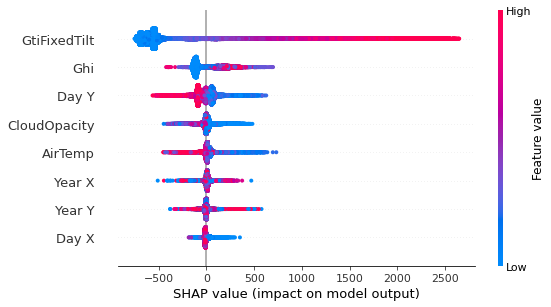

In [28]:
# Test set SHAP plot

plt.figure(figsize=(8, 6))
shap.summary_plot(temp_shap, X_test['upac08'])

In [29]:
# Add season information to dataframes

def extract_season(df):
    
    date = df.index.month*100 + df.index.day
    df['season'] = (pd.cut(date,[0,321,620,922,1220,1300],
                           labels=['winter','spring','summer','autumn','winter '])
                    #.str.strip()
                   )
    df['season'] = df['season'].str.replace(' ', '')
    df['season'] = df['season'].astype('category')
    
    df['season_int'] = df['season'].cat.codes
    
    return

df_model = temp_shap_df.copy(deep=True)
extract_season(df_model)
df_model.drop('season_int', inplace=True, axis=1)

df_testx = X_test['upac08'].copy(deep=True)
extract_season(df_testx)
df_testx.drop('season_int', inplace=True, axis=1)

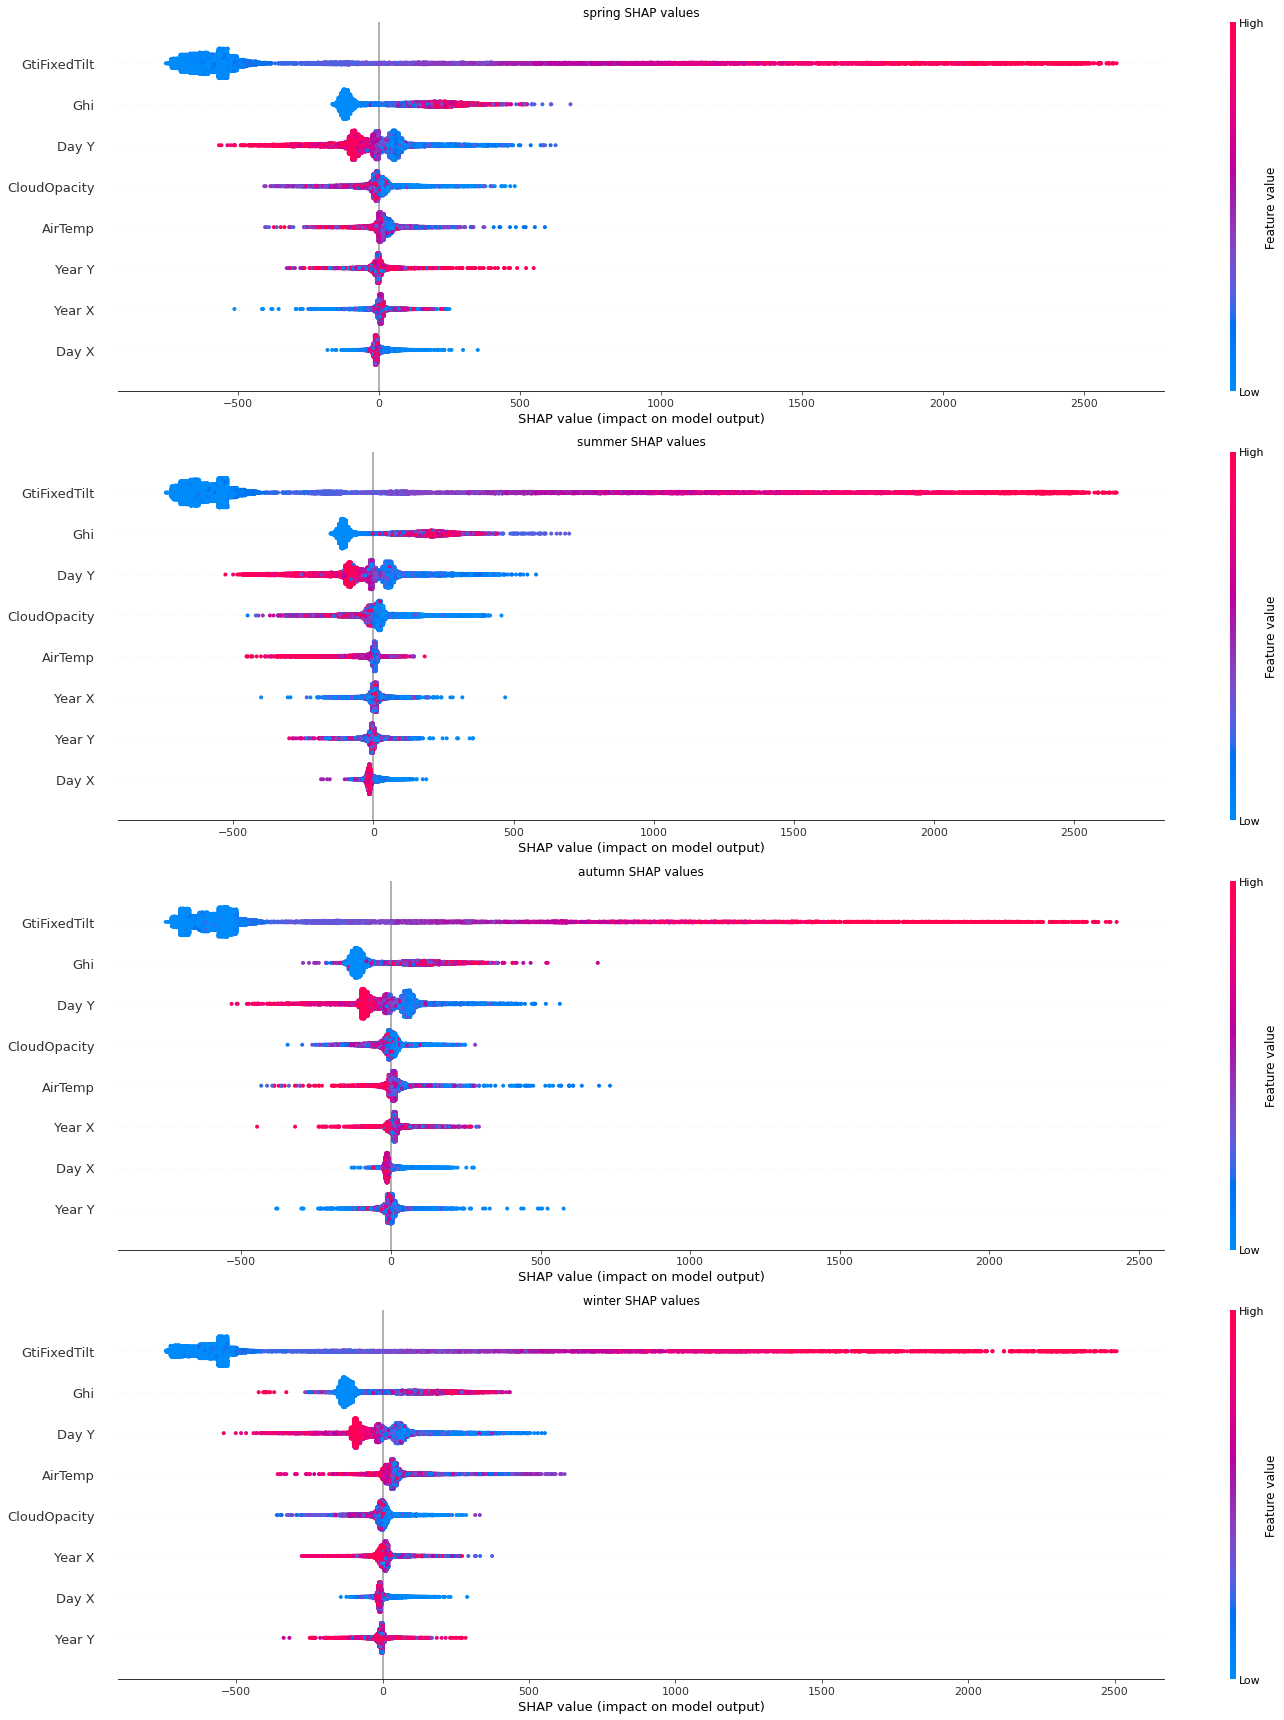

In [30]:
# Model Season analysis

fig = plt.figure(figsize=(20, 24))
current_axs = 0

for season in df_model['season'].unique():
    plt.subplot(4, 1, current_axs+1)
    
    season_shap = df_model.loc[df_model['season'] == season].drop(['season'], axis=1).values
    season_data = df_testx.loc[df_testx['season'] == season].drop(['season'], axis=1)
    
    temp_axs = shap.summary_plot(season_shap, season_data,
                                 plot_size=None, show=False)
    plt.title('{} SHAP values'.format(season))
    current_axs += 1
    
plt.tight_layout()

In [32]:
# Model 08 SHAP values for each season

season_shap = {}
for season in df_model['season'].unique():
    season_shap[season] = np.abs(df_model.loc[df_model['season'] == season].drop('season', axis=1)).describe().loc['mean']
    
season_shap = pd.DataFrame(season_shap)
season_shap = season_shap.reindex(columns=['autumn', 'winter', 'spring', 'summer'])
season_shap = season_shap.transpose()

season_shap = season_shap.reindex(columns=['GtiFixedTilt', 'Ghi', 'CloudOpacity', 'Day Y', 'Day X', 'Year Y', 'Year X'])

In [33]:
# Show the SHAP values by season

season_shap

,GtiFixedTilt,Ghi,CloudOpacity,Day Y,Day X,Year Y,Year X
autumn,622.405762,110.465187,30.575888,80.132126,20.871984,20.733538,24.268732
winter,652.605225,126.713272,30.055403,84.457809,19.298841,16.606327,23.806112
spring,733.056824,148.352921,47.958752,96.158333,18.893715,26.597881,22.300215
summer,797.078369,147.260162,60.156307,106.556465,19.838320,21.369970,22.709705
